## Load libraries

In [234]:
import yt
import caesar
import numpy as np
import matplotlib.pyplot as plt

import swiftemulator as se
from swiftemulator.design import latin
from swiftemulator.io.swift import load_parameter_files
from swiftemulator.emulators import gaussian_process, gaussian_process_mcmc
from swiftemulator.sensitivity import basic, cross_check, cross_check_bins
from swiftemulator.mocking import mock_sweep

import swiftpipeline as sp

import os
from glob import glob
from pathlib import Path

## Load simulated data (galaxy functions, scaling relations, ...)

In [25]:
num_calis = 16
#cali_list = ["cali_%s" % str(i).zfill(4) for i in range(num_calis)]
cali_list = ["cali_%04d" % i for i in range(num_calis)]
print(cali_list)

['cali_0000', 'cali_0001', 'cali_0002', 'cali_0003', 'cali_0004', 'cali_0005', 'cali_0006', 'cali_0007', 'cali_0008', 'cali_0009', 'cali_0010', 'cali_0011', 'cali_0012', 'cali_0013', 'cali_0014', 'cali_0015']


In [34]:
snap_prefix = 'doug_s18n128'
snap_num = '0015'
#cali_num = 'cali_0000'
snap_dir = '/scratch/b/babul/aspadawe/swift_tests/cali_simba'

In [238]:
#snaps = []
#caesars = []
gsmf_logM = []
gsmf_Phi = []

for cali in cali_list:
#    snap = os.path.join(snap_dir, cali, snap_prefix+'_'+snap_num+'.hdf5')
#    caesar_file = os.path.join(snap_dir, cali_num, snap_prefix+'_caesar_'+snap_num+'.hdf5')
    gsmf_file = os.path.join(snap_dir, cali, snap_prefix+'_gsmf_limited_'+snap_num+'.txt')
    print(gsmf_file)
    
#    ds = yt.load(snap)
#    snaps.append(ds)
    
#    obj = caesar.load(caesar_file)
#    caesars.append(obj)

    data = np.loadtxt(gsmf_file)
    logM = data[:,0]
    Phi = data[:,1]
    
    gsmf_logM.append(logM)
    gsmf_Phi.append(Phi)
    
#print(gsmf_logM)
#print(gsmf_Phi)

/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0000/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0001/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0002/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0003/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0004/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0005/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0006/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0007/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0008/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0009/doug_s18n128_gsmf_limited_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0010/d

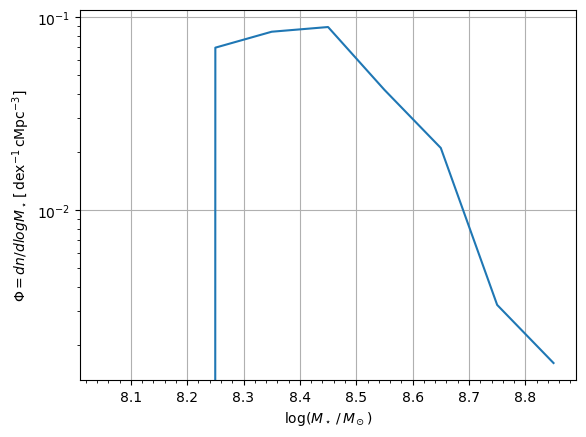

In [275]:
# Plot one of the GSMFs to check it worked
check = 0

#fig, ax = plt.subplots()
plt.clf()
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}]$')
#plt.title(r'%s, snap %s, z=%s, nbins=%s' % (cali_num, snap_num, z, nbins))
#plt.ylabel(r'$\log{(\Phi\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])}$')
#plt.plot(Max,Phi,ls='steps-post')
plt.grid()
plt.minorticks_on()
#plt.tick_params(axis="y",direction="in")#, left="off",labelleft="on")
plt.plot(gsmf_logM[check],gsmf_Phi[check],ls='-')
#plt.plot(Max,np.log10(Phi),ls='-')

## Specify the model parameters and values

In [241]:
parameter_files = [Path(x) for x in glob("/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/*.yml")]
parameter_filenames = {filename.stem: filename for filename in parameter_files}
print(parameter_files)
print()
print(parameter_filenames)

[PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/4.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/14.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/5.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/2.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/15.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/0.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/8.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/6.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/3.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/1.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/11.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/9.yml'), 

In [242]:
model_specification, model_parameters = load_parameter_files(
    filenames=parameter_filenames,
    parameters=[
        "SIMBAAGN:xray_f_gas_limit",
        "SIMBAAGN:f_accretion",
        "SIMBAAGN:torque_accretion_norm",
        "SIMBAAGN:wind_momentum_flux"
    ],
    log_parameters=[
    ],
    parameter_printable_names=[
        "$f_{\\rm gas,xray}$",
        "$f_{\\rm acc}$",
        "$\epsilon_{\\rm torque}$",
        "Momentum flux"
    ],
)
print(model_specification)
print()
print(model_parameters)

ModelSpecification(number_of_parameters=4, parameter_names=['SIMBAAGN:xray_f_gas_limit', 'SIMBAAGN:f_accretion', 'SIMBAAGN:torque_accretion_norm', 'SIMBAAGN:wind_momentum_flux'], parameter_limits=[[0.2484490482517083, 0.9535354367676403], [0.06382175956324224, 0.3895955351217842], [0.07321359834183083, 0.4719937222653178], [21.487637984541763, 97.03335554421214]], parameter_printable_names=['$f_{\\rm gas,xray}$', '$f_{\\rm acc}$', '$\\epsilon_{\\rm torque}$', 'Momentum flux'])

ModelParameters(model_parameters={'4': {'SIMBAAGN:xray_f_gas_limit': 0.2804346099979346, 'SIMBAAGN:f_accretion': 0.3123626717299527, 'SIMBAAGN:torque_accretion_norm': 0.3557999320624141, 'SIMBAAGN:wind_momentum_flux': 55.39631118088475}, '14': {'SIMBAAGN:xray_f_gas_limit': 0.2484490482517083, 'SIMBAAGN:f_accretion': 0.19771832096391256, 'SIMBAAGN:torque_accretion_norm': 0.12727635950863653, 'SIMBAAGN:wind_momentum_flux': 91.59071772026137}, '5': {'SIMBAAGN:xray_f_gas_limit': 0.34893982287895886, 'SIMBAAGN:f_accr

In [243]:
modelvalues = {}
for unique_identifier in model_parameters.model_parameters:
    independent = gsmf_logM[int(unique_identifier)]
    dependent = gsmf_Phi[int(unique_identifier)]
    dependent_error = 0.0 * dependent
    modelvalues[unique_identifier] = {"independent": independent,
                                    "dependent": dependent,
                                    "dependent_error": dependent_error}
#    modelvalues[unique_identifier] = {"independent": independent,
#                                      "dependent": dependent}

model_values = se.ModelValues(model_values=modelvalues)
print(modelvalues)
print()
print(model_values)

{'4': {'independent': array([8.05, 8.15, 8.25, 8.35, 8.45, 8.55, 8.65, 8.75, 8.85]), 'dependent': array([0.        , 0.        , 0.06117589, 0.0982034 , 0.09337373,
       0.04346708, 0.01126924, 0.00482968, 0.00160989]), 'dependent_error': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, '14': {'independent': array([8.05, 8.15, 8.25, 8.35, 8.45, 8.55, 8.65, 8.75, 8.85]), 'dependent': array([0.        , 0.        , 0.04829676, 0.10303308, 0.08210448,
       0.05634621, 0.02092859, 0.00804946, 0.        ]), 'dependent_error': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, '5': {'independent': array([8.05, 8.15, 8.25, 8.35, 8.45, 8.55, 8.65, 8.75, 8.85]), 'dependent': array([0.        , 0.        , 0.03541762, 0.10303308, 0.08854405,
       0.05634621, 0.02092859, 0.00160989, 0.        ]), 'dependent_error': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, '2': {'independent': array([8.05, 8.15, 8.25, 8.35, 8.45, 8.55, 8.65, 8.75, 8.85]), 'dependent': array([0.        , 0.        , 0.04829676, 

## Train emulator

In [244]:
gsmf_emulator = gaussian_process.GaussianProcessEmulator()
gsmf_emulator.fit_model(model_specification=model_specification,
                            model_parameters=model_parameters,
                            model_values=model_values)

In [245]:
gsmf_emulator

GaussianProcessEmulator(kernel=ConstantKernel(log_constant=-1.6094379124341003, ndim=5, axes=array([0, 1, 2, 3, 4])) * ExpSquaredKernel(metric=Metric(array([1., 1., 1., 1., 1.]), ndim=5, axes=array([0, 1, 2, 3, 4]), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None)]), block=None), mean_model=None)

In [276]:
gsmf_emulator.parameter_order

['SIMBAAGN:xray_f_gas_limit',
 'SIMBAAGN:f_accretion',
 'SIMBAAGN:torque_accretion_norm',
 'SIMBAAGN:wind_momentum_flux']

## Make predictions and compare

In [248]:
model_parameters['0']

{'SIMBAAGN:xray_f_gas_limit': 0.9535354367676403,
 'SIMBAAGN:f_accretion': 0.21475691826279325,
 'SIMBAAGN:torque_accretion_norm': 0.4475036358483602,
 'SIMBAAGN:wind_momentum_flux': 73.62769640233914}

In [249]:
model_values['0']['independent']

array([8.05, 8.15, 8.25, 8.35, 8.45, 8.55, 8.65, 8.75, 8.85])

In [250]:
model_values['0']['dependent']

array([0.        , 0.        , 0.06922535, 0.08371438, 0.08854405,
       0.04185719, 0.02092859, 0.00321978, 0.00160989])

In [277]:
# Make predictions with trained emulator to compare to input

num = '0'
pred_params = model_parameters[num]
pred_x = model_values[num]['independent']
sim_y = model_values[num]['dependent']

pred_y, pred_var = gsmf_emulator.predict_values(pred_x, pred_params)
print(pred_y)
print()
print(pred_var)

[-1.41048978e-11  6.57310456e-11  6.92253483e-02  8.37143736e-02
  8.85440481e-02  4.18571869e-02  2.09285932e-02  3.21978384e-03
  1.60989185e-03]

[1.25000010e-12 1.24999967e-12 1.25000032e-12 1.24999989e-12
 1.24999989e-12 1.24999967e-12 1.25000010e-12 1.25000032e-12
 1.25000032e-12]


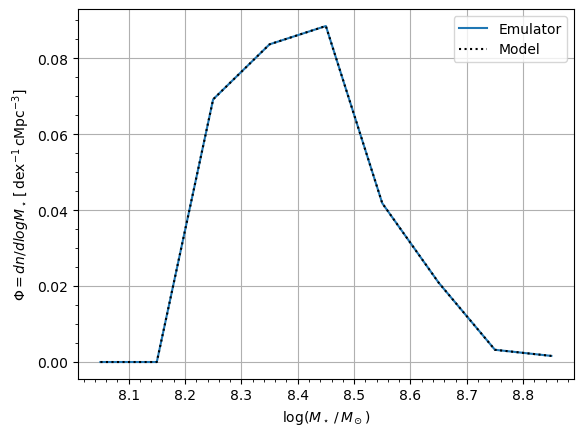

In [281]:
plt.clf()
#plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}]$')
#plt.title(r'%s, snap %s, z=%s, nbins=%s' % (cali_num, snap_num, z, nbins))
plt.grid()
plt.minorticks_on()
plt.plot(pred_x, pred_y,ls='-', label='Emulator')
plt.plot(pred_x, sim_y, color="black", ls=":", label="Model")
plt.legend()

## Parameter sensitivity analysis

In [261]:
gsmf_sensitivities = basic.binwise_sensitivity(specification=model_specification,
                                             parameters=model_parameters,
                                             values=model_values)
gsmf_sensitivities

/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/SALib/analyze/rbd_fast.py:129: RuntimeWarning: invalid value encountered in double_scalars
  return D1 / V


{'8.05': array([nan, nan, nan, nan]),
 '8.15': array([nan, nan, nan, nan]),
 '8.25': array([1., 1., 1., 1.]),
 '8.35': array([1., 1., 1., 1.]),
 '8.45': array([1., 1., 1., 1.]),
 '8.55': array([1., 1., 1., 1.]),
 '8.65': array([1., 1., 1., 1.]),
 '8.75': array([1., 1., 1., 1.]),
 '8.85': array([1., 1., 1., 1.])}

(<Figure size 360x171.429 with 2 Axes>,
 <Axes: xlabel='$\\log(M_\\star\\,/\\,M_\\odot)$'>)

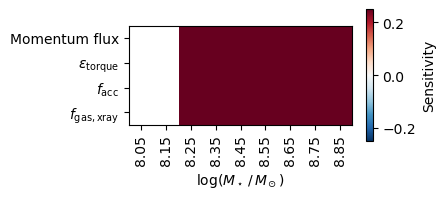

In [262]:
basic.plot_binwise_sensitivity(specification=model_specification,
                               sensitivities=gsmf_sensitivities,
                              xlabel=r'$\log(M_\star\,/\,M_\odot)$',
                              cbarlabel='Sensitivity')

## Perform cross check (validation)

In [263]:
gsmf_ccheck = cross_check.CrossCheck()
gsmf_ccheck.build_emulators(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

/tmp/ipykernel_234114/3206653632.py:6: RuntimeWarning: divide by zero encountered in divide
  cc_over_og = data_by_cc[unique_identifier]["dependent"] / \


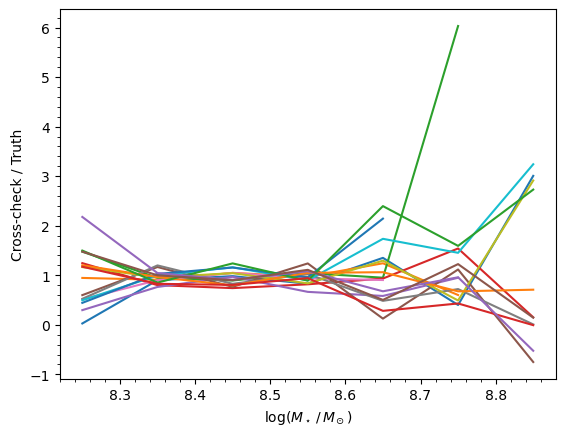

In [265]:
data_by_cc = gsmf_ccheck.build_mocked_model_values_original_independent()
#print(data_by_cc)

for unique_identifier in model_values.model_values:
#    print(unique_identifier)
    cc_over_og = data_by_cc[unique_identifier]["dependent"] / \
                model_values[unique_identifier]["dependent"]
#    cc_minus_og_over_og = (data_by_cc[unique_identifier]["dependent"] / \
#                           model_values[unique_identifier]["dependent"])/ model_values[unique_identifier]["dependent"]
    plt.plot(data_by_cc[unique_identifier]["independent"],cc_over_og)
    plt.grid()
    plt.minorticks_on()
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel("Cross-check / Truth")

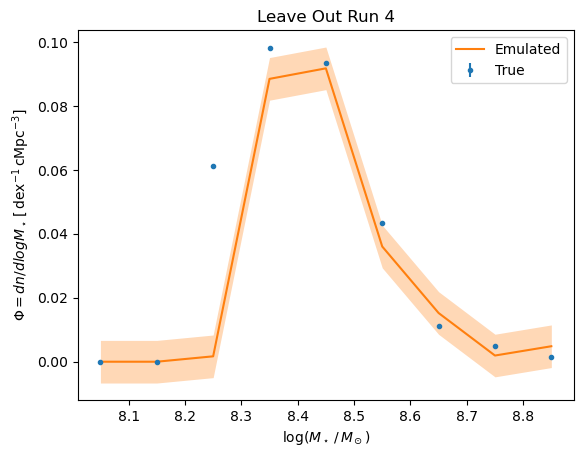

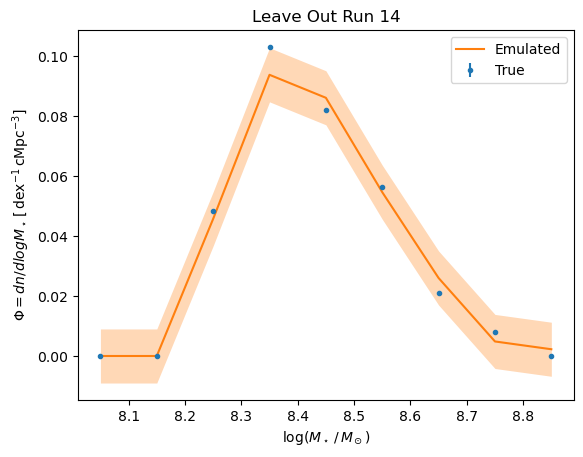

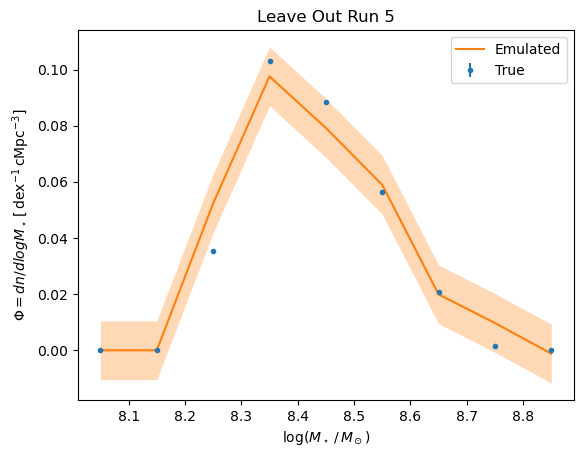

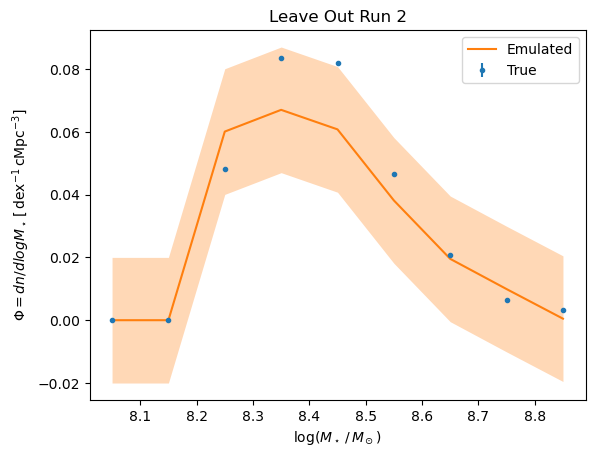

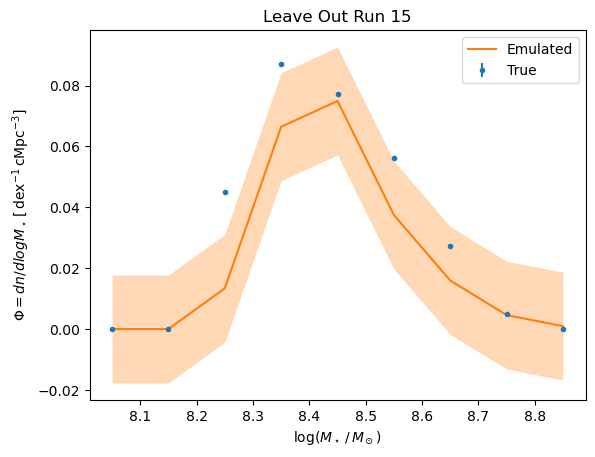

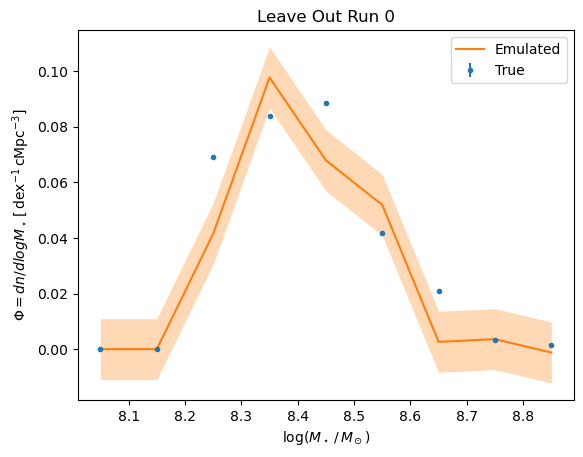

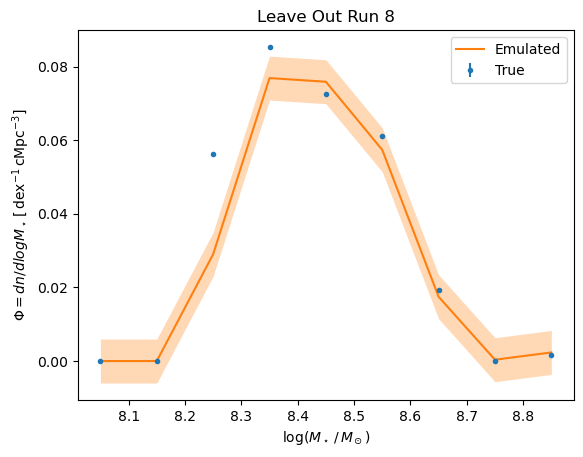

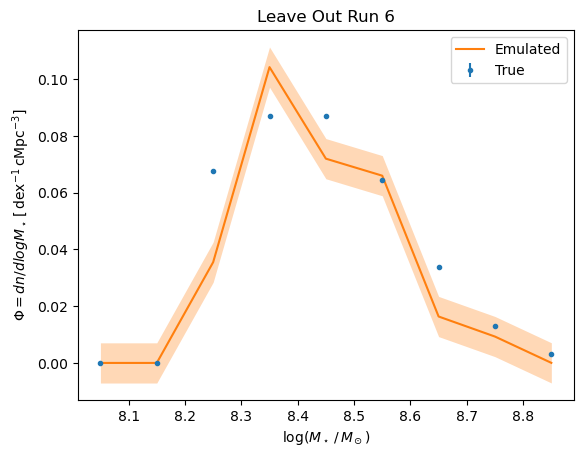

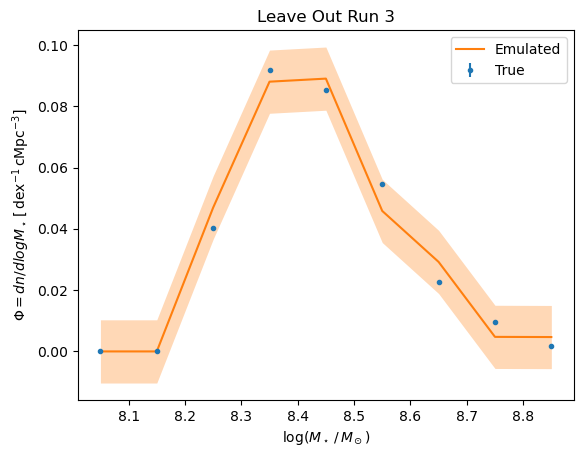

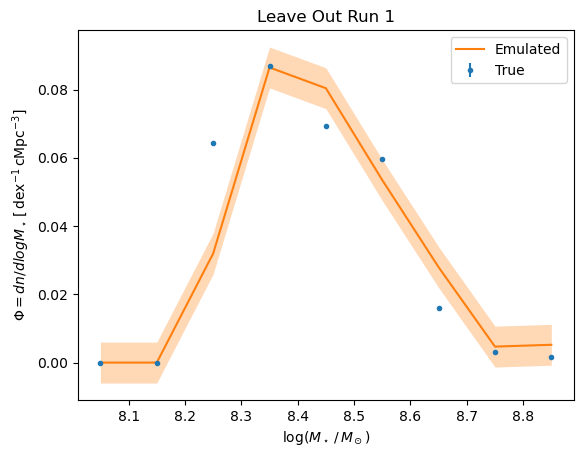

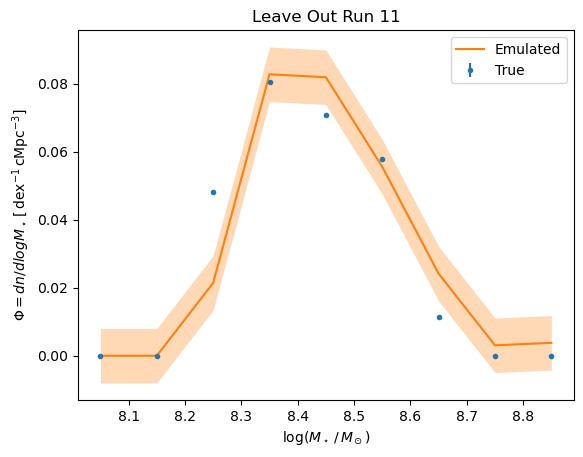

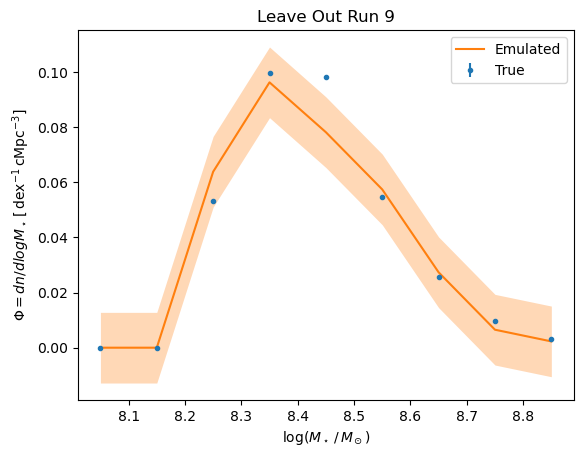

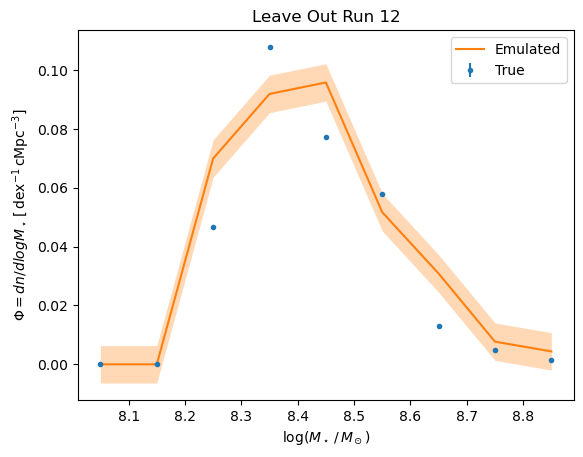

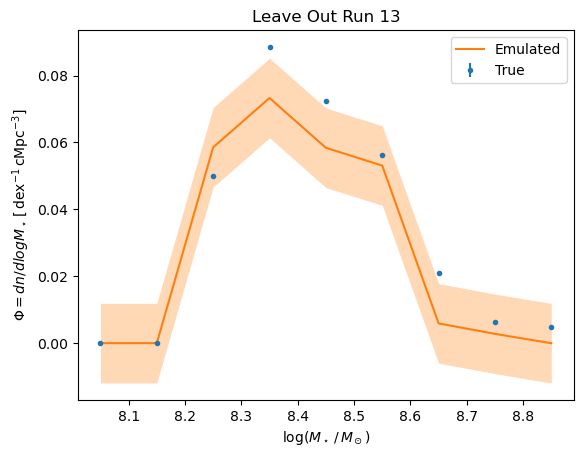

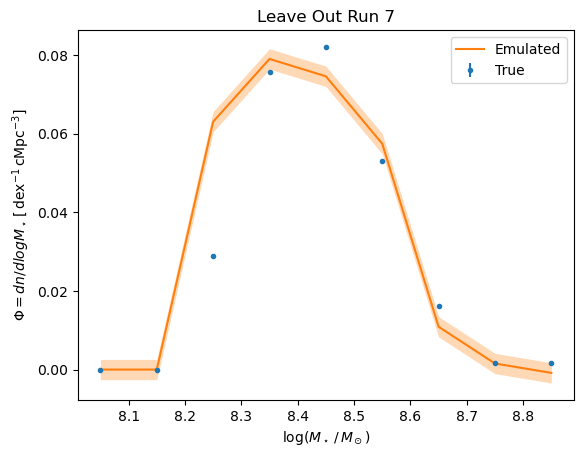

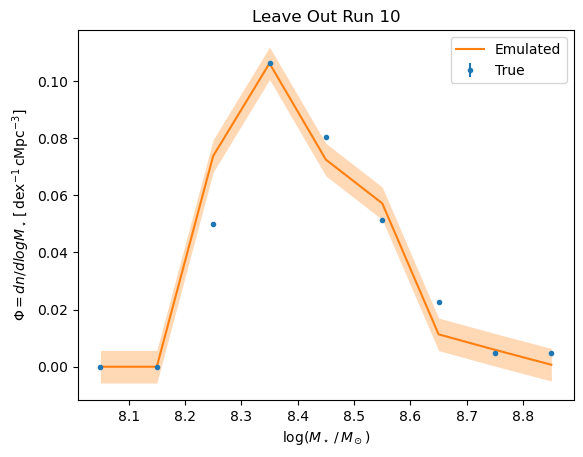

In [266]:
gsmf_ccheck.plot_results(emulate_at=data_by_cc[unique_identifier]["independent"],
                        xlabel=r'$\log(M_\star\,/\,M_\odot)$',
                        ylabel=r'$\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}]$')

In [267]:
total_mean_squared = gsmf_ccheck.get_mean_squared()[0]
print("Total mean squared of entire set of left-out simulations: %s" % total_mean_squared)

Total mean squared of entire set of left-out simulations: 0.0001345915379775084


## Perform binned cross check (doesn't work)

In [268]:
gsmf_ccheck_bins = cross_check_bins.CrossCheckBins()
gsmf_ccheck_bins.build_emulators(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

TypeError: predict_values() missing 1 required positional argument: 'independent'

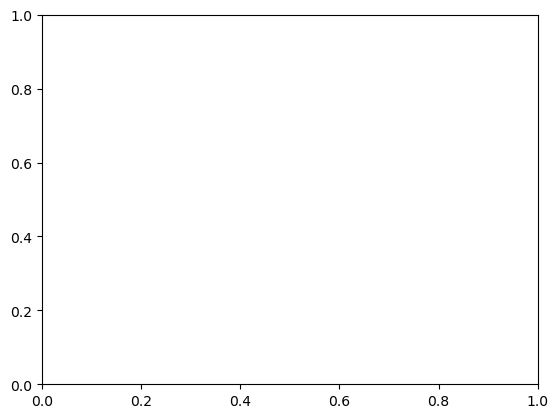

In [269]:
gsmf_ccheck_bins.plot_results(xlabel=r'$\log(M_\star\,/\,M_\odot)$',
                              ylabel=r'$\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}]$')

In [270]:
total_mean_squared = gsmf_ccheck_bins.get_mean_squared()[0]
print("Total mean squared of entire set of left-out simulations: %s" % total_mean_squared)

ValueError: not enough values to unpack (expected 3, got 2)

## Model Parameter Features

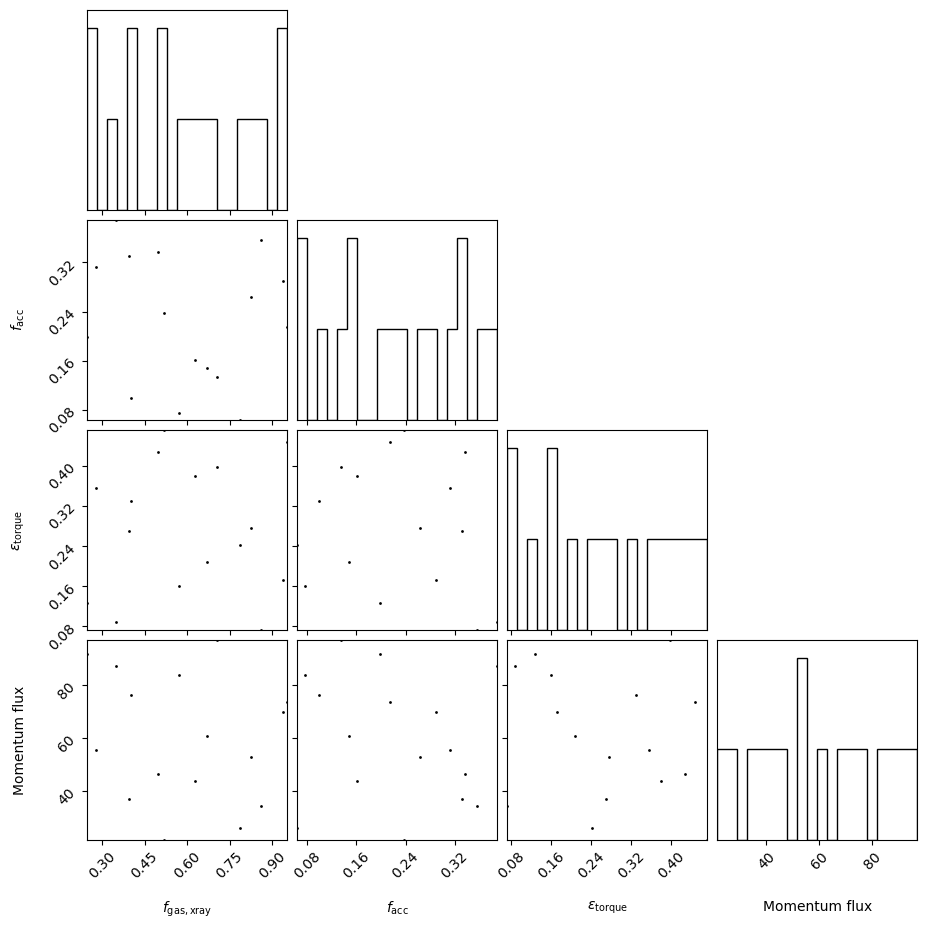

In [271]:
model_parameters.plot_model(model_specification)

In [272]:
# Models closest to best model
# But don't know best model yet b/c I haven't compared to observations yet

best_model = gsmf_emulator.model_parameters['0']

model_parameters.find_closest_model(best_model,number_of_close_models=5)

(['0', '12', '3', '6', '10'],
 [{'SIMBAAGN:xray_f_gas_limit': 0.9535354367676403,
   'SIMBAAGN:f_accretion': 0.21475691826279325,
   'SIMBAAGN:torque_accretion_norm': 0.4475036358483602,
   'SIMBAAGN:wind_momentum_flux': 73.62769640233914},
  {'SIMBAAGN:xray_f_gas_limit': 0.40187076318649934,
   'SIMBAAGN:f_accretion': 0.09897074647673551,
   'SIMBAAGN:torque_accretion_norm': 0.32992087498483613,
   'SIMBAAGN:wind_momentum_flux': 75.96049144263723},
  {'SIMBAAGN:xray_f_gas_limit': 0.9396273438695912,
   'SIMBAAGN:f_accretion': 0.28909115515459843,
   'SIMBAAGN:torque_accretion_norm': 0.1719681283477677,
   'SIMBAAGN:wind_momentum_flux': 69.56978679165695},
  {'SIMBAAGN:xray_f_gas_limit': 0.5701273027190352,
   'SIMBAAGN:f_accretion': 0.07541927270328372,
   'SIMBAAGN:torque_accretion_norm': 0.15996305465419988,
   'SIMBAAGN:wind_momentum_flux': 83.82898331458352},
  {'SIMBAAGN:xray_f_gas_limit': 0.6706117490018764,
   'SIMBAAGN:f_accretion': 0.14724561528138613,
   'SIMBAAGN:torque_acc

## Sweeps of parameter space

{'SIMBAAGN:xray_f_gas_limit': 0.34893982287895886, 'SIMBAAGN:f_accretion': 0.3895955351217842, 'SIMBAAGN:torque_accretion_norm': 0.0891591824169552, 'SIMBAAGN:wind_momentum_flux': 86.93557418827176}


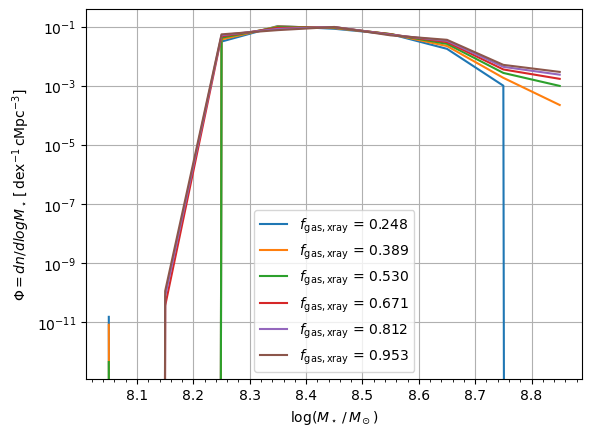

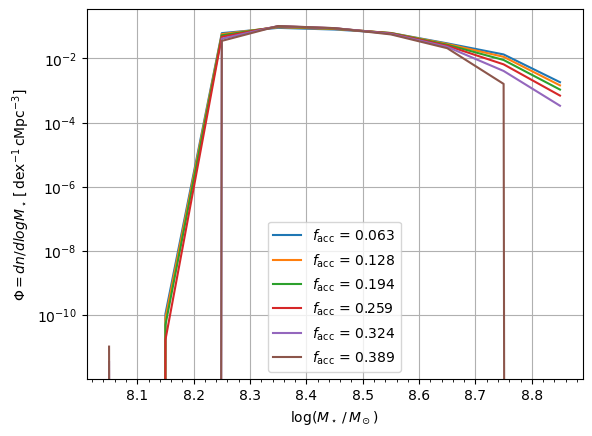

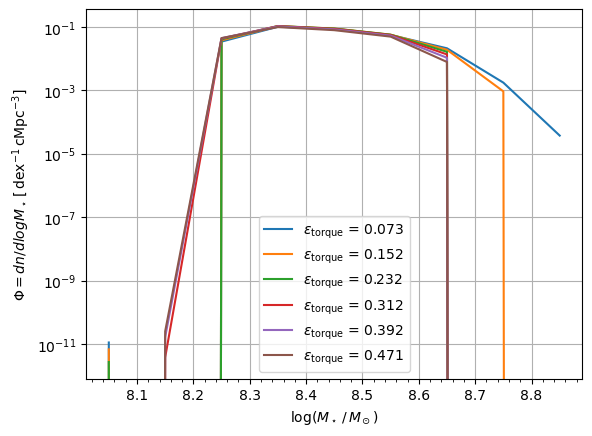

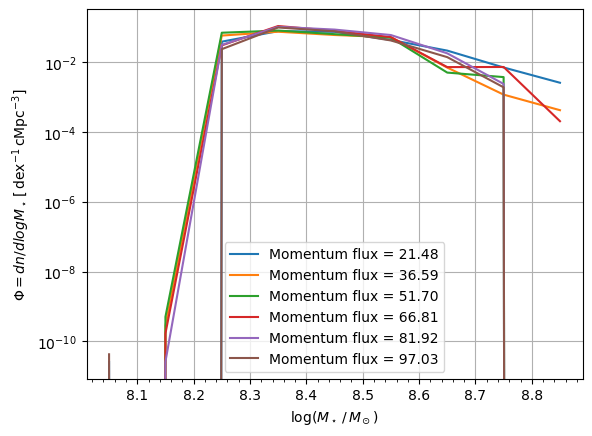

In [284]:
# Arbitrarily choose initial parameters to sweep from
# Doesn't matter too much though, because it ends up covering
# roughly the entire range of parameters used
# Although it seems the emulator results are somewhat sensitive to the exact parameters used

center = gsmf_emulator.model_parameters['5']
print(center)

for ii in range(len(gsmf_emulator.parameter_order)):
    param_name = gsmf_emulator.parameter_order[ii]
    param_printable_name = gsmf_emulator.model_specification.parameter_printable_names[ii]
    
    Mock_values, Mock_parameters = mock_sweep(gsmf_emulator
                                      ,model_specification
                                      ,6,param_name,center)
#    print(Mock_parameters)
    plt.clf()
    
    for mock_name in Mock_values.keys():
        plt.plot(Mock_values[mock_name]["independent"],
                Mock_values[mock_name]["dependent"],
                label = "%s = " % param_printable_name +str(Mock_parameters[mock_name][param_name])[:5])
    
    plt.yscale('log')
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel(r'$\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}]$')
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Checking hyperparameters (doesn't work)

In [274]:
gsmf_emulator_mcmc = gaussian_process_mcmc.GaussianProcessEmulatorMCMC(burn_in_steps=1
                                                                          ,mcmc_steps=1000)
gsmf_emulator_mcmc.fit_model(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

gmsf_emulator_mcmc.plot_hyperparameter_distribution()

emcee: Exception while calling your likelihood function:
  params: [-8.12800239e+00 -7.71651837e+02  2.73303295e+00 -6.21546281e-02
 -1.70905871e+00  5.59236120e+00]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/gpfs/fs1/home/b/babul/aspadawe/src/emulator/swiftemulator/emulators/gaussian_process_mcmc.py", line 249, in log_likelihood
    return -negative_log_likelihood(p)
  File "/gpfs/fs1/home/b/babul/aspadawe/src/emulator/swiftemulator/emulators/gaussian_process_mcmc.py", line 242, in negative_log_likelihood
    return -gaussian_process.log_likelihood(self.dependent_variables)
  File "/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/george/gp.py", line 385, in log_likelihood
    if not self.recompute(quiet=quiet):
  File "/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/george/gp.py", line 355, in recompute
    self.compute(self._x, np.sqrt(self._yerr2), **kwargs)
  File "/home/b/babul/aspadawe/miniconda3

ValueError: array must not contain infs or NaNs